In [ ]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [131]:
#create data frame object
patient_df = pd.read_csv('diabetes_dataset_with_notes.csv')

In [132]:
#look at the parts of the df
patient_df.head()
patient_df.tail()
patient_df.info()
patient_df.describe()
print(" Chart of Null Values:\n", patient_df.isnull().sum())
print(" Number of Duplicates: ", patient_df.duplicated().sum() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

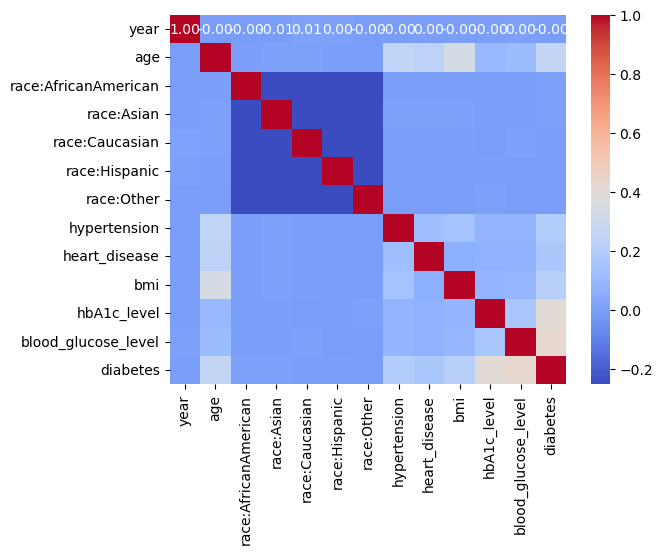

In [133]:
#heat map tells us that there are no major corelations found within the dataset that would need correction 
dataplot = sb.heatmap(patient_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

In [134]:
#remove missing values (not nessary but good practice)
patient_df_clean = patient_df.dropna()
#remove duplicates
df_clean = patient_df_clean.drop_duplicates()

In [135]:
# separate features and target
#dropped smoking history as there are many null features (no info) and it would mess up the results
#dropped location and clinical notes are trying to predict using medical data as to allow for the extroplation of results beyond this test
X = df_clean.drop(columns=['diabetes' , 'smoking_history', 'location', 'clinical_notes']) 
y = df_clean['diabetes']             

#encode catororical variables (gender)
le = LabelEncoder()
X['gender'] = le.fit_transform(X['gender'])

#scale numeric features
numerical_columns = X.drop(columns=['gender']).columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

diabetes
0    91486
1     8500
Name: count, dtype: int64


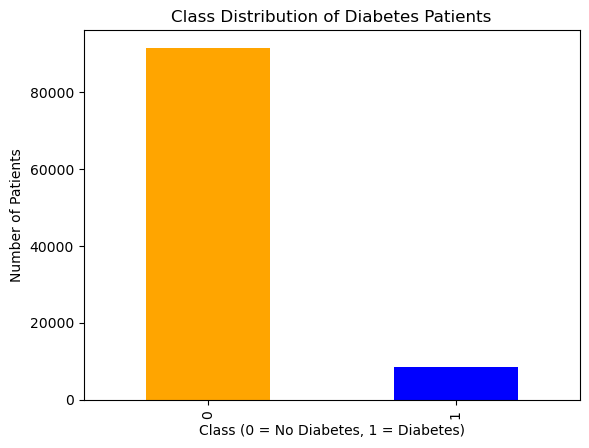

In [136]:
class_counts = df_clean['diabetes'].value_counts()
print(class_counts)

class_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Class Distribution of Diabetes Patients')
plt.xlabel('Class (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Number of Patients')
plt.show()

In [137]:
#set smote state for repeatablilty
smote = SMOTE(random_state=42)
# fit SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

#check that the operation has been performed correctly 
from collections import Counter
print("Original class distribution:", Counter(y))
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({0: 91486, 1: 8500})
Resampled class distribution: Counter({0: 91486, 1: 91486})


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#check shape to ensure success
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")

Training Features Shape: (146377, 13)
Testing Features Shape: (36595, 13)
Training Target Shape: (146377,)
Testing Target Shape: (36595,)


In [ ]:
# LOGISTIC REGRESSION FUNCTION DEFINTIONS
#sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#cost function
def cost_function(theta, X, y):
    m = len(y)
    # @ means matrix multiplication got this from geeks_for_geeks / numpy functions
    h = sigmoid(X @ theta)
    return (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

# funtion to perform gradient descent
def gradient_descent(X, y, alpha=0.01, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

# found that _ can be used in place of i for a loop if you don't need to count iterations (pretty cool in my opinion)
    for _ in range(iterations):
        theta -= alpha * (1/m) * (X.T @ (sigmoid(X @ theta) - y))
        cost_history.append(cost_function(theta, X, y))

    return theta, cost_history

In [ ]:
# LOGISTIC REGRESSION IMPLIMENTATION
# Add intercept term
X_resampled = np.c_[np.ones(X_resampled.shape[0]), X_resampled]

# take a random sample of 15% of the total dataset
sample_size = int(0.2 * len(X_resampled))
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(X_resampled), size=sample_size, replace=False)

X_sampled = X_resampled[sample_indices]
y_sampled = y_resampled[sample_indices]

# shuffle sampled data
shuffled_indices = np.random.permutation(len(X_sampled))

X_sampled = X_sampled[shuffled_indices]
y_sampled = np.array(y_sampled)[shuffled_indices]


# define the split
split_index = int(0.8 * len(X_sampled))

#split the dataset 80-20
X_train, X_test = X_sampled[:split_index], X_sampled[split_index:]
y_train, y_test = y_sampled[:split_index], y_sampled[split_index:]

# Confirm
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# train the model
theta_optimal, cost_history = gradient_descent(X, y, alpha=0.01, iterations=800)
# make predictions (threshold was optimized at .8)
y_pred_manual = (sigmoid(X @ theta_optimal) >= 0.8).astype(int)

print("Accuracy:", accuracy_score(y, y_pred_manual))
print("Precision:", precision_score(y, y_pred_manual))
print("Recall:", recall_score(y, y_pred_manual))
print("F1 Score:", f1_score(y, y_pred_manual))

#compute confusion matrix
cm = confusion_matrix(y, y_pred_manual)

#show confusion matrix
plt.figure(figsize=(5,4))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Manual Logistic Regression")
plt.show()

# plot cost function for debugging and optimal criteria selection
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Gradient Descent Convergence")
plt.show()